In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.cifar_resnet import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNNL2
from lib.utils import *
from lib.lip_model import *
from lib.cifar10_model import *

# from lib.cifar10_dcgan import Discriminator, Generator

Loading faiss with AVX2 support.


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_cifar10_all(
    '/data', val_size=0.1, seed=seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


---

Load Models

In [6]:
# model_name = 'cifar10_basic_rn.h5'
model_name = 'cifar10_at_rn.h5'
# model_name = 'adv_cifar10_exp%d.h5' % exp_id
# model_name = 'train_cifar10_vae_exp%d.h5' % exp_id
# model_name = 'rot_cifar10_exp%d.h5' % exp_id
# model_name = 'ae_cifar10_exp%d.h5' % exp_id

In [14]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=10)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True
net.load_state_dict(torch.load('saved_models/cifar10/' + model_name))
net = net.module
net = net.eval().to('cuda')

In [8]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2]).eval()
config = {'num_steps': 8,
          'step_size': 0.05,
          'random_start': True,
          'loss_func': 'xent'}
net = PGDL2Model(net, config)

net.load_state_dict(torch.load('saved_models/cifar10/' + model_name))
net = net.basic_net
net = net.eval().to('cuda')

In [ ]:
net = CIFAR10_VAE((3, 32, 32), latent_dim=128)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [57]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=4)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [44]:
net = CIFAR10_AE((3, 32, 32), latent_dim=128)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [9]:
net

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

In [20]:
ind = np.zeros(x_test.size(0))
with torch.no_grad():
    num = 0
    for i in range(x_test.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net(x_test[begin:end].to('cuda'))
        ind[begin:end] = (y_pred.argmax(1).cpu() == y_test[begin:end]).numpy()
        num += (y_pred.argmax(1).cpu() == y_test[begin:end]).sum().numpy()
    print(num / y_test.size(0))
ind = np.where(ind)[0]

0.8045


In [21]:
ind = ind[:100]

In [24]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=10, max_iterations=1000,
            confidence=0, learning_rate=1e-2,
            initial_const=1e1, abort_early=False)
    return x_adv

x_adv = attack_batch(x_test[ind].cuda(), y_test[ind].cuda(), 100)

    step: 0; loss: 30.836; l2dist: 0.000
    step: 100; loss: 2.474; l2dist: 1.385
    step: 200; loss: 2.265; l2dist: 1.348
    step: 300; loss: 2.224; l2dist: 1.343
    step: 400; loss: 2.202; l2dist: 1.337
    step: 500; loss: 2.192; l2dist: 1.337
    step: 600; loss: 2.185; l2dist: 1.330
    step: 700; loss: 2.181; l2dist: 1.337
    step: 800; loss: 2.168; l2dist: 1.329
    step: 900; loss: 2.157; l2dist: 1.325
binary step: 0; number of successful adv: 89/100
    step: 0; loss: 51.983; l2dist: 0.000
    step: 100; loss: 2.878; l2dist: 1.433
    step: 200; loss: 2.404; l2dist: 1.359
    step: 300; loss: 2.346; l2dist: 1.352
    step: 400; loss: 2.303; l2dist: 1.346
    step: 500; loss: 2.298; l2dist: 1.352
    step: 600; loss: 2.263; l2dist: 1.339
    step: 700; loss: 2.253; l2dist: 1.338
    step: 800; loss: 2.237; l2dist: 1.336
    step: 900; loss: 2.202; l2dist: 1.332
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 30.527; l2dist: 0.000
    step: 100; loss: 2

In [25]:
ind_adv = np.zeros(x_adv.size(0))
with torch.no_grad():
    num = 0
    for i in range(x_adv.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net(x_adv[begin:end].to('cuda'))
        ind_adv[begin:end] = (y_pred.argmax(1).cpu() != y_test[ind][begin:end]).numpy()
        num += (y_pred.argmax(1).cpu() == y_test[ind][begin:end]).sum().numpy()
    print(num / x_adv.size(0))
ind_adv = np.where(ind_adv)[0]

0.0


In [26]:
pert = (x_adv.cpu() - x_test[ind]).view(x_adv.size(0), -1).norm(2, 1)
d1 = (len(ind) - (pert[ind_adv] < 0.5).sum().numpy()) / y_test.size(0)
d2 = (len(ind) - (pert[ind_adv] < 1).sum().numpy()) / y_test.size(0)
d3 = (len(ind) - (pert[ind_adv] < 1.5).sum().numpy()) / y_test.size(0)
print('& %.4f & %.4f & %.4f' % (d1, d2, d3))

& 0.0083 & 0.0063 & 0.0033


In [27]:
pert[ind_adv].mean()

tensor(1.2168, grad_fn=<MeanBackward0>)

---

## DkNN

In [28]:
layers = ['layer4']

dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=5, num_classes=10)

In [29]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.7825


In [47]:
# Load x_adv from file
# Skip this if you you want to generate attacks on the notebook

x_adv = pickle.load(open('x_adv/x_adv_cifar10_resnet_exp2.h5.p', 'rb'))

with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    ind_adv = np.where(y_pred.argmax(1) != y_test[ind].numpy())[0]
    print((y_pred.argmax(1) == y_test[ind].numpy()).sum() / y_pred.shape[0])

In [14]:
from lib.dknn_attack_l2 import DKNNL2Attack
attack = DKNNL2Attack()

def attack_batch(x, y, batch_size, layer):
    x_a = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_a[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layer, m=300, binary_search_steps=10,
            max_iterations=500, learning_rate=1e-2, initial_const=1e-5,
            abort_early=False, random_start=True, guide_mode=2)
    return x_a

num = 100
ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100, layers[0])

KeyboardInterrupt: 

In [ ]:
from lib.dknn_attack_exp import DKNNExpAttack

attack = DKNNExpAttack(dknn)

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end],
            guide_layer=layers[0], m=6, binary_search_steps=10,
            max_iterations=1000, learning_rate=1e-2,
            initial_const=1e-2, random_start=False,
            thres_steps=200, check_adv_steps=200, verbose=True)
    return x_adv

num = 100
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100)

    step: 0; loss: 21.100; l2dist: 0.000
    step: 100; loss: 2.900; l2dist: 1.321
    step: 200; loss: 5.201; l2dist: 1.305
    step: 300; loss: 2.720; l2dist: 1.291
    step: 400; loss: 3.637; l2dist: 1.284
    step: 500; loss: 2.557; l2dist: 1.299
    step: 600; loss: 3.194; l2dist: 1.308
    step: 700; loss: 2.531; l2dist: 1.281
    step: 800; loss: 3.008; l2dist: 1.283
    step: 900; loss: 2.393; l2dist: 1.273
tensor(68., device='cuda:0')
binary step: 0; number of successful adv: 86/100
    step: 0; loss: 86.745; l2dist: 0.000
    step: 100; loss: 3.584; l2dist: 1.420
    step: 200; loss: 14.398; l2dist: 1.390
    step: 300; loss: 3.533; l2dist: 1.397
    step: 400; loss: 8.149; l2dist: 1.367
    step: 500; loss: 3.216; l2dist: 1.376
    step: 600; loss: 6.926; l2dist: 1.363
    step: 700; loss: 2.996; l2dist: 1.353
    step: 800; loss: 6.676; l2dist: 1.374
    step: 900; loss: 3.086; l2dist: 1.388
tensor(78., device='cuda:0')
binary step: 1; number of successful adv: 97/100
    s

(array([93.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.0584 , 0.15256, 0.24672, 0.34088, 0.43504, 0.5292 , 0.62336,
        0.71752, 0.81168, 0.90584, 1.     ]),
 <a list of 10 Patch objects>)

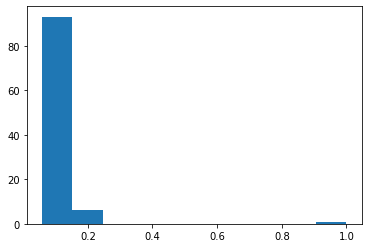

In [38]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [34]:
y_pred = dknn.classify(x_adv)
acc = (y_pred.argmax(1) == y_test[ind][:num].numpy()).sum() / len(y_pred)
print('Accuracy on x_adv: %.4f' % acc)

ind_adv = np.where(y_pred.argmax(1) != y_test[ind][:num].numpy())[0]
dist = np.sqrt(np.sum((x_adv.cpu().detach().numpy() - x_test.numpy()[ind][:num])[ind_adv]**2, (1, 2, 3)))
print('Mean distance: %.4f' % np.mean(dist))

Accuracy on x_adv: 0.0000
Mean distance: 1.0605


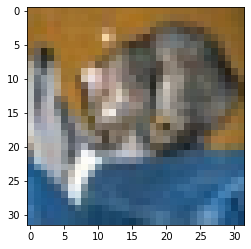

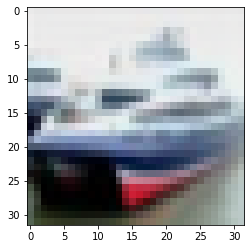

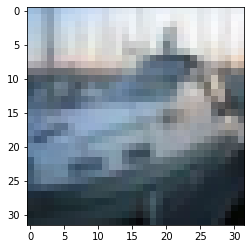

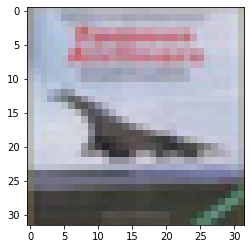

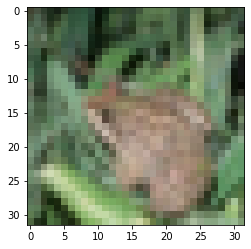

In [34]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().permute(1, 2, 0).numpy())
    plt.show()

---

## RotNet

Train small network on top of pre-trained rotation network

In [27]:
opt = {'num_classes': 4, 'num_stages': 4}
net = NetworkInNetwork(opt)

In [28]:
net.load_state_dict(torch.load('saved_models/model_net_epoch200')['network'])

In [29]:
net = net._feature_blocks

In [30]:
net_wrap = NINWrapper(net, block=2)
net_wrap = net_wrap.cuda().eval()

In [33]:
# net_wrap.fc = nn.Sequential(
#     nn.Linear(12288, 200),
#     nn.ReLU(inplace=True),
#     nn.Linear(200, 200),
#     nn.ReLU(inplace=True),
#     nn.Linear(200, 128))
net_wrap.fc = nn.Sequential(
    nn.Linear(12288, 2000),
    nn.ReLU(inplace=True),
    nn.Linear(2000, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 128))
net_wrap = net_wrap.to('cuda')

In [44]:
net_wrap.load_state_dict(torch.load('saved_models/transfer_cifar10_exp11.h5'))

In [81]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=4)
net.load_state_dict(torch.load('saved_models/rot_cifar10_exp0.h5'))
net_wrap = ResNetWrapper(net, block=3, dim=16384)
for param in net_wrap.parameters():
    param.requires_grad = False
# net_wrap.fc = nn.Sequential(
#     nn.Linear(16384, 2000),
#     nn.ReLU(inplace=True),
#     nn.Linear(2000, 400),
#     nn.ReLU(inplace=True),
#     nn.Linear(400, 128),
# )
net_wrap.fc = nn.Sequential(
    nn.BatchNorm1d(16384),
    nn.Linear(16384, 2000),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(2000),
    nn.Linear(2000, 400),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(400),
    nn.Linear(400, 128),
)
net_wrap.load_state_dict(torch.load('saved_models/transfer_cifar10_exp18.h5'))
net_wrap = net_wrap.to('cuda').eval()

In [82]:
layers = ['fc']

dknn = DKNNL2(net_wrap, x_train, y_train, x_valid, y_valid, layers, 
              k=1, num_classes=10)

In [101]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.7015


In [99]:
with torch.no_grad():
    num = 0
    for i in range(x_test.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net_wrap(x_test[begin:end].to('cuda'))
        num += (y_pred.argmax(1).cpu() == y_test[begin:end]).sum().numpy()
    print(num / y_test.size(0))

0.0011


In [59]:
x_adv = pickle.load(open('x_adv/x_adv_adv_cifar10_exp0.h5.p', 'rb'))
# x_adv = pickle.load(open('x_adv/x_ba_cifar10_adv2_0.2_0.001.p', 'rb'))
# x_adv = pickle.load(open('x_adv/x_adv_cifar10_resnet_exp2.h5.p', 'rb'))

In [56]:
torchvision.utils.save_image(x_adv[:10], 'cifar10_cw_adv.png', nrow=10, padding=0)

In [10]:
torchvision.utils.save_image(x_test[:10], 'cifar10_test.png', nrow=10, padding=0)

In [75]:
diff = x_adv[:10].cpu() - x_test[:10]
torchvision.utils.save_image(diff, 'diff_cw_adv.png', nrow=10, padding=0, normalize=True)

In [50]:
(x_adv - x_test[ind])[:100].view(100, -1).norm(2, 1)

tensor([0.1601, 0.1639, 0.0439, 0.0925, 0.2344, 0.1875, 0.1263, 0.0629, 0.1313,
        0.0308, 0.1699, 0.2601, 0.1186, 0.2549, 0.2104, 0.0949, 0.0168, 0.1908,
        0.2373, 0.2276, 0.0749, 0.1144, 0.0599, 0.3487, 0.0113, 0.1286, 0.0399,
        0.1052, 0.1184, 0.1812, 0.1033, 0.1054, 0.1015, 0.0491, 0.2473, 0.1405,
        0.1351, 0.3051, 0.2656, 0.1246, 0.1826, 0.1177, 0.1306, 0.2810, 0.2485,
        0.0251, 0.0446, 0.2726, 0.0799, 0.2484, 0.1870, 0.0150, 0.0376, 0.1555,
        0.1845, 0.0784, 0.0302, 0.0403, 0.0080, 0.1847, 0.1957, 0.1100, 0.0935,
        0.1443, 0.0339, 0.1736, 0.0629, 0.1216, 0.0863, 0.1177, 0.0650, 0.1191,
        0.1149, 0.3842, 0.2538, 0.1573, 0.1572, 0.1589, 0.0625, 0.2314, 0.1450,
        0.0575, 0.0426, 0.0426, 0.0458, 0.2055, 0.2434, 0.1804, 0.0808, 0.2458,
        0.2491, 0.0758, 0.0949, 0.1004, 0.0661, 0.2742, 0.2168, 0.0666, 0.0765,
        0.2380])

In [ ]:
(x_adv.cpu() - x_test[ind][:100]).view(100, -1).norm(2, 1)